# Parte 1: Concept Similarity

Nella prima parte utilizziamo 2 risorse lessicali per un task di **concept similarity**. Le risorse sono
* Wordnet, utilizzando le API fornite da NLTK
* WordSim353, un corpus in cui abbiamo una lista di triple (word1, word2, similarity value).

L'obiettivo di questa parte è implementare 3 misure di similarity basate sulla struttura tassonomica di Wordnet:

* *Wu Palmer Similarity*

$$ \operatorname{sim}(s1,s2) = \frac{2\cdot\operatorname{depth}(LCS(s1,s2))}{\operatorname{depth}(s1) + \operatorname{depth}(s2)} $$

Dove $LCS(s1,s2)$ è il *Lowest Common Subsumer*, ovvero il sysnset **comune** più vicino ai synsets $s1,s2$ nella gerarchia iperonimi/iponimi. $\operatorname{depth}(s)$ è la profondità (distanza minima) del synset $s$ dalla radice.

* *Shortest Path Similarity*

$$ \operatorname{sim}(s1,s2) = 2\cdot\operatorname{depthMax} - \operatorname{len}(s1,s2) $$

* *Leakcock-Chodorow Similarity*

$$ \operatorname{sim}(s1,s2) = -\log\frac{\operatorname{len}(s1,s2)}{2\cdot\operatorname{depthMax}} $$


$\operatorname{depthMax}$ è una costante che caratterizza la massima profondità della tassomia. Dunque è la distanza tra la radice della tassomia e la foglia alla massima profondità. Dato che Wordnet partiziona il lessico in base a 4 Part-of-Speech (POS)(Noun, Verb, Adjective, Adverb), il valore $\operatorname{depthMax}$ dipende dal particolare POS considerato. 


In [1]:
from pathlib import Path
import pandas as pd
import src.concept_similarity as cs
import src.data_manager as dm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import nltk

# required lexical resources/ corpus
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### EDA del corpus WordSim353

Vediamo alcuni esempi di annotazioni presenti nel corpus. Selezioniamo le coppie di parole che corrispondo rispettivamente al
minimo, primo quartile, mediana, secondo quartile e massimo dello score di similarità.

In [2]:

wordsim353 = dm.WordSimCorpus(Path('data/WordSim353.csv'))
wordsim_df = pd.DataFrame(wordsim353, columns=['word1','word2','gold_score'])

example_words = pd.DataFrame()
for qpos in [0.0, 0.25, 0.5, 0.75, 1.0]: # sample word pair for each quartile
    quantile = wordsim_df['gold_score'].quantile(q=qpos, interpolation='nearest')
    example_words = example_words.append(wordsim_df[wordsim_df['gold_score']== quantile].sample())

example_words

,word1,word2,gold_score
33,king,cabbage,0.023
343,observation,architecture,0.438
347,shower,thunderstorm,0.631
45,tennis,racket,0.756
2,tiger,tiger,1.000


Da notare che :

$$\operatorname{sim}: S\times S \to \mathbb{R}$$

Ovvero le metriche di similarità prendono in input due synset e restituiscono uno score numerico. Dunque bisogna implementare un meccanismo che prenda in input due **word forms** e restituisca uno score di similarità considerando che per il fenomeno della **polisemia** una word-form può avere differenti significati e dunque appartenere a differenti synsets. A tal proposito definiamo la word similarity come:

$$ \operatorname{sim}(w_1, w_2) = \operatorname*{max}_{\substack{c_1 \in \operatorname{Syn}(w_1)\\ c_2 \in \operatorname{Syn}(w_2) }} \operatorname{sim}(c_1,c_2)$$

Dove $\operatorname{Syn}(w)$ è l'insieme dei synsets in cui occorre la word-form $w$.

Vediamo su questi esempi selezionati il comportamento delle rispettive metriche di similarità.

In [3]:
metrics = [(cs.wu_palmer_similarity, 'wu_palmer'), 
           (cs.shortest_path_similarity, 'shortest_path'),
           (cs.leakcock_chodorow_similarity, 'leakcock_chodorow')]
    
    
for metric, metric_name in metrics:
    example_words[metric_name] = example_words.apply(lambda x: cs.word_similarity(x['word1'], x['word2'], metric), axis=1)
    
example_words


,word1,word2,gold_score,wu_palmer,shortest_path,leakcock_chodorow
33,king,cabbage,0.023,0.689655,0.775,1.410987
343,observation,architecture,0.438,0.761905,0.875,1.921813
347,shower,thunderstorm,0.631,0.785714,0.850,1.767662
45,tennis,racket,0.756,0.733333,0.800,1.516347
2,tiger,tiger,1.000,1.000000,1.000,3.713572


Possiamo osservare che, per gli esempi selezionati, non sussiste un forte agreement con il "gold score".
Inoltre il valore delle metriche non è direttamente comparabaile in quanto le scale sono differenti.

In generale, si può osservare che all'aumentare della similarità indicata dal gold score, aumenta anche
il valore calcolato delle tre metriche.

### Correlazione
Vediamo di seguito l'agreement tra i gli score di similarità target (presenti nel corpus come annotazioni) e quelli calcolati dalle rispettive metriche.

Come primo step calcoliamo le metriche di similarità per ogni coppia di temini presenti nel corpus:

In [4]:
for metric, metric_name in metrics:
    wordsim_df[metric_name] = wordsim_df.apply(lambda x: cs.word_similarity(x['word1'], x['word2'], metric), axis=1)

Di seguito calcoliamo gli indici di correlazione di pearson e spearman. Utilizziamo i metodi delle API di Pandas, ricordando dalla documentazione:

> "Compute pairwise correlation of columns, excluding NA/null values."

In [5]:
excluded_cols = [name for metric, name in metrics]
(wordsim_df.corr(method='pearson')
           .drop(excluded_cols,axis=1)
           .drop('gold_score'))

,gold_score
wu_palmer,0.329174
shortest_path,0.257977
leakcock_chodorow,0.351304


In [6]:
(wordsim_df.corr(method='spearman')
           .drop(excluded_cols,axis=1)
           .drop('gold_score'))

,gold_score
wu_palmer,0.327861
shortest_path,0.314281
leakcock_chodorow,0.314281


Entrambi gli indici, non sembrano indicare una forte correlazione positiva. Possiamo verificarlo visivamente dai seguenti scatter plot:

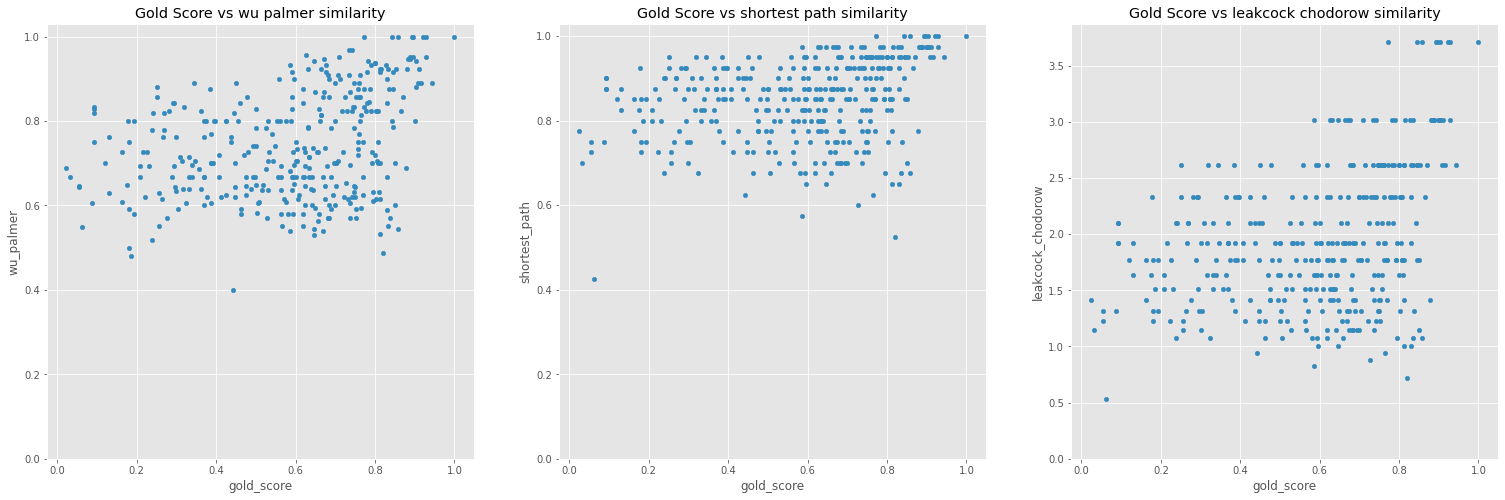

In [7]:
fig, axes = plt.subplots(1,3,figsize=(26,8))
for ax, metric_name in zip(axes, [name for metric, name in metrics]):
    #ax.scatter(x=wordsim_df['gold_score'], y=wordsim_df[metric_name])
    wordsim_df.plot.scatter(x='gold_score', y=metric_name, ax=ax)
    ax.set_ylim(bottom=0.0)
    ax.set_title("Gold Score vs {} similarity".format(metric_name.replace('_',' ')))

# Parte 2: Word Sense Disambiguation

In questa seconda parte vedremo come utilizzare l'algoritmo *Lesk* per un task di *Word Sense Disambiguation* (WSD). Utilizzeremo un breve corpus di frasi, ognuna contenente un singolo senso polisemico che dovrà essere disambiguato utilizando l'algoritomo Lesk e dunque sfruttando le risorse lessicali codificate in WordNet.

In [8]:
from nltk.corpus import wordnet as wn
import src.word_sense_disambiguation as wsd
import numpy as np

wn.synsets('word')[0]._wordnet_corpus_reader.get_version() # quick hack to retrieve wordnet version used by NLTK

'3.0'

Ma cosa significa nella pratica che un termine è polisemico? Vediamo un semplice esempio per una frase presa dal corpus.

In [9]:
corpus_path = Path('data/sentences.txt')
corpus = dm.WSDSentences(corpus_path)

_, poly_word, sentence = corpus.get_sentences()[0]
print("Chosen sentence: {}\n".format(sentence))

for syn in wn.synsets(poly_word):
    example = syn.examples()[0] if len(syn.examples()) != 0 else '' 
    print("{} sense: {}\nDefinition: {}\nExample: {}\n".format(poly_word, syn.name(), syn.definition(), example))

Chosen sentence: Arms bend at the elbow.

Arms sense: weaponry.n.01
Definition: weapons considered collectively
Example: 

Arms sense: coat_of_arms.n.01
Definition: the official symbols of a family, state, etc.
Example: 

Arms sense: arm.n.01
Definition: a human limb; technically the part of the superior limb between the shoulder and the elbow but commonly used to refer to the whole superior limb
Example: 

Arms sense: arm.n.02
Definition: any projection that is thought to resemble a human arm
Example: the arm of the record player

Arms sense: weapon.n.01
Definition: any instrument or instrumentality used in fighting or hunting
Example: he was licensed to carry a weapon

Arms sense: arm.n.04
Definition: the part of an armchair or sofa that supports the elbow and forearm of a seated person
Example: 

Arms sense: branch.n.01
Definition: a division of some larger or more complex organization
Example: a branch of Congress

Arms sense: sleeve.n.01
Definition: the part of a garment that is a

Quindi per il termine "Arm" esistono differenti significati dipendenti dal contesto preso in considerazione. Nel caso specifico, il contesto espresso dalla frase
si riferisce chiaramente ad "Arm" nel senso di parte anatomica.

Di seguito utilizziamo l'algoritmo Lesk per disambiguare la parola indicata nel corpus.

In [10]:
    output_path = Path("output")
    output_path.mkdir(parents=True, exist_ok=True)
    out_file = output_path / 'wsd_sentences.txt'

    with out_file.open('w') as file:
        for key, word, sentence in corpus.get_sentences(): # for each sentence
            best_sense, _ = wsd.lesk_wsd(sentence, word)

            if best_sense: # a sense is found for a given word
                repl_string = '[{}]'.format(', '.join(best_sense.lemma_names()))
                syn_name = best_sense.name()
                syn_definition = best_sense.definition()
            else:
                repl_string = '[NONE]'
                syn_name = ''
                syn_definition = ''

            repl_sentence = corpus.replace_polysemous_word(key, repl_string)
            to_write = "{} | {} | {}\n".format(repl_sentence, syn_name, syn_definition)
            print(to_write)
            file.write(to_write)


[coat_of_arms, arms, blazon, blazonry] bend at the elbow. | coat_of_arms.n.01 | the official symbols of a family, state, etc.

Germany sells [coat_of_arms, arms, blazon, blazonry] to Saudi Arabia. | coat_of_arms.n.01 | the official symbols of a family, state, etc.

The [key] broke in the lock. | key.n.01 | metal device shaped in such a way that when it is inserted into the appropriate lock the lock's mechanism can be rotated

The [Key, Francis_Scott_Key] problem was not one of quality but of quantity. | key.n.07 | United States lawyer and poet who wrote a poem after witnessing the British attack on Baltimore during the War of 1812; the poem was later set to music and entitled `The Star-Spangled Banner' (1779-1843)

Work out the [solution] in your head. | solution.n.01 | a homogeneous mixture of two or more substances; frequently (but not necessarily) a liquid solution

Heat the [solution, answer, result, resolution, solvent] to 75° Celsius. | solution.n.02 | a statement that solves a p

La precedente cella costruisce le bag-of-words non considerando la rimozione delle stopword. Vediamo di seguito se e come influsice la rimozione delle stop words sull'algoritmo lesk.

In [11]:
    with out_file.open('w') as file:
        for key, word, sentence in corpus.get_sentences():
            best_sense, _ = wsd.lesk_wsd(sentence, word, stopwords=wsd.STOP_WORDS)

            if best_sense: # a sense is found for a given word
                repl_string = '[{}]'.format(', '.join(best_sense.lemma_names()))
                syn_name = best_sense.name()
                syn_definition = best_sense.definition()
            else:
                repl_string = '[NONE]'
                syn_name = ''
                syn_definition = ''

            repl_sentence = corpus.replace_polysemous_word(key, repl_string)
            to_write = "{} | {} | {}\n".format(repl_sentence, syn_name, syn_definition)
            print(to_write)
            file.write(to_write)

[coat_of_arms, arms, blazon, blazonry] bend at the elbow. | coat_of_arms.n.01 | the official symbols of a family, state, etc.

Germany sells [coat_of_arms, arms, blazon, blazonry] to Saudi Arabia. | coat_of_arms.n.01 | the official symbols of a family, state, etc.

The [key] broke in the lock. | key.n.01 | metal device shaped in such a way that when it is inserted into the appropriate lock the lock's mechanism can be rotated

The [Key, Francis_Scott_Key] problem was not one of quality but of quantity. | key.n.07 | United States lawyer and poet who wrote a poem after witnessing the British attack on Baltimore during the War of 1812; the poem was later set to music and entitled `The Star-Spangled Banner' (1779-1843)

Work out the [solution] in your head. | solution.n.01 | a homogeneous mixture of two or more substances; frequently (but not necessarily) a liquid solution

Heat the [solution] to 75° Celsius. | solution.n.01 | a homogeneous mixture of two or more substances; frequently (but

 Analizziamo i risultati:
* Solamente $5$ su $14$ de termini polisemici totali sono stati disambiguati **correttamente**, con un'accuratezza dunque dello $0.35$%.
* In $2$ casi su $14$ l'algoritmo lesk **non è riuscito a trovare un senso** per il termine polisemico. Nello specifico, questo significa che non è r
riuscito a trovare un senso in cui la signature e il contesto avessero un valore di overlap $>0$.
* Un esempio peculiare è il caso delle 2 frasi:

>Work out the [solution] in your head. | solution.n.01 | a homogeneous mixture of two or more substances; frequently (but not necessarily) a liquid solution
>Heat the [solution, answer, result, resolution, solvent] to 75° Celsius. | solution.n.02 | a statement that solves a problem or explains how to solve the problem

in cui l'algoritmo ha invertito esattamente i corrispettivi sensi corretti.

* Inoltre, dalla seconda esecuzione, si può notare un **peggioramento** delle prestazione eliminando le **stopwords**.

Come è possibile interpretare questi risultati? La riduzione delle prestazioni della seconda esecuzione ci fornisce un indizio importante. L'algoritmo con brevi frasi ha pessime prestazioni in quanto non riesce a trovare dei sensi con overlap $>0$, denotando dunque una certa **dipendenza dalle stopwords**, comportamento certamente non desiderabile, in quanto esse non catturano il contesto della frase.

### SemCor Evaluation

Effettuiamo un task di word sense disambiguation utilizzando l'algoritmo Lesk su un differente corpus: *SemCor*. 

In [12]:
def accuracy(true, predicted):
    correct_predictions = sum([true_sense.lower() == predicted_sense.lower() for true_sense, predicted_sense in zip(true, predicted)
    if true_sense and predicted_sense])
    return correct_predictions / len(true)

In [14]:
semcor_files = [Path('data/semcor3.0/br-e21'),
                Path('data/semcor3.0/br-j59'),
                Path('data/semcor3.0/br-r07'),
                Path('data/semcor3.0/br-k25'),
                Path('data/semcor3.0/br-p01')]


accuracy_scores = []
for file_path in semcor_files:
    semcor = dm.SemCorCorpus(file_path)

    true_senses =  []
    predicted_senses = []

    for sentence, annotated_words in semcor.get_annotated_sentences():
        for (word, true_sense_id) in annotated_words:
            lesk_sense, _ = wsd.lesk_wsd(sentence, word)
            lesk_sense_name = lesk_sense.name() if lesk_sense else None
            
            true_senses.append(true_sense_id)
            predicted_senses.append(lesk_sense_name)
    
    accuracy_scores.append(accuracy(true_senses, predicted_senses))

In [16]:
accuracy_scores = np.array(accuracy_scores)
for file, acc_score in  zip(semcor_files, accuracy_scores):
    print("Accuracy on {} file: {:.4f}".format(file.stem, acc_score))
    
print('Achieved {:.3f}+-{:.2f} mean accuracy on {} runs'.format(accuracy_scores.mean(),
accuracy_scores.std(), len(accuracy_scores)))    


Accuracy on br-e21 file: 0.2364
Accuracy on br-j59 file: 0.1656
Accuracy on br-r07 file: 0.1641
Accuracy on br-k25 file: 0.2310
Accuracy on br-p01 file: 0.2581
Achieved 0.211+-0.04 mean accuracy on 5 runs


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=afb22156-bb61-4d65-847d-18db79c0d4d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>